In [1]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import torch
from gensim.models import Word2Vec
import numpy as np
import gensim
from sklearn.decomposition import TruncatedSVD
import spacy
import logging
from tqdm import tqdm
from spacy.pipeline import EntityRuler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import AutoTokenizer, AutoModel
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-03-30 18:48:08.464824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 18:48:08.478084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-30 18:48:08.492591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-30 18:48:08.497038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 18:48:08.508787: I tensorflow/core/platform/cpu_feature_guar

In [2]:
emotion_mapping = {
    "joy": "happiness",
    "amusement": "happiness",
    "admiration": "happiness",
    "gratitude": "happiness",
    "optimism": "happiness",
    "pride": "happiness",
    "excitement": "happiness",
    "love": "happiness",
    "relief": "happiness",
    "caring": "happiness",
    "approval": "happiness",
    'happiness': 'happiness',

    "disappointment": "sadness",
    "grief": "sadness",
    "sadness": "sadness",
    "remorse": "sadness",

    "annoyance": "anger",
    "disapproval": "anger",
    "anger": "anger",

    "surprise": "surprise",
    "realization": "surprise",
    "confusion": "surprise",

    "fear": "fear",
    "nervousness": "fear",

    "disgust": "disgust",
    "emberrasment": "disgust",

    "neutral": "neutral",
    'curiosity': 'neutral'
}

# DATASET https://huggingface.co/datasets/Aniemore/resd_annotated



In [3]:
import pandas as pd

df_go_ru = pd.read_parquet("hf://datasets/seara/ru_go_emotions/raw/train-00000-of-00001-86de8ef1d0ae28df.parquet")
print(df_go_ru.shape)

(211225, 38)


In [4]:
# Drop columns that are not represented by core emotions
dataset_go = df_go_ru.drop(df_go_ru.columns[2:10], axis=1)

# Drop senteces with sum of columns 2:-1 equal to 0 (basically deletes the rows with no emotion)
dataset_go = dataset_go[dataset_go.iloc[:, 2:].sum(axis=1) > 0]
print(f'Number of deleted rows: {df_go_ru.shape[0] - dataset_go.shape[0]}')

# Reset index
dataset_go = dataset_go.reset_index(drop=True)

print(dataset_go.shape)

Number of deleted rows: 3411
(207814, 30)


In [5]:
# Function to split sparse rows into separate rows
def split_sparse_rows(df):
    expanded_rows = []
    
    for _, row in df.iterrows():
        sparse_cols = [col for col in df.columns if row[col] == 1]  # Get columns with '1's
        for col in sparse_cols:
            new_row = row.copy()
            for c in sparse_cols:
                new_row[c] = 0  # Reset all sparse values
            new_row[col] = 1  # Keep only one '1' per row
            expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows)

# Apply transformation
dataset_go = split_sparse_rows(dataset_go)

dataset_go.shape

(249529, 30)

In [6]:
# Combine sparse columns into a single 'emotion' column
dataset_go['emotion'] = dataset_go.iloc[:, 2:].idxmax(axis=1)

# Drop the original sparse columns
dataset_go = dataset_go.drop(columns=dataset_go.columns[2:-1])

In [7]:
# Function to apply majority voting
def majority_vote(series):
    return series.mode()[0] if not series.mode().empty else series.iloc[0]

# Apply majority voting on 'emotion' while keeping both 'ru_text' and 'text'
cleaned_df = dataset_go.groupby("ru_text", as_index=False).agg({
    "text": "first",  # Keep the first English translation
    "emotion": majority_vote  # Apply majority voting on emotion
})

cleaned_df.shape

(57573, 3)

In [8]:
# Map emotions to core emotions
cleaned_df['general_emotion'] = cleaned_df['emotion'].map(emotion_mapping)
cleaned_df.head()

,ru_text,text,emotion,general_emotion
0,! напомни мне через 2 дня,! remind me 2 days,neutral,neutral
1,! хороший бот,! good bot,admiration,happiness
2,!!!!! Лучшая девушка,!!!!! Best girl,admiration,happiness
3,!Messagemecreepypost,!Messageme creepypost,neutral,neutral
4,"!delta Не понимаю, почему бы и нет",!delta I don't see why not,neutral,neutral


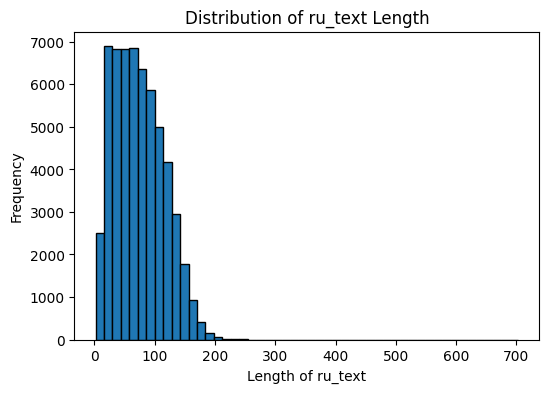

In [9]:
import matplotlib.pyplot as plt

# Calculate the length of each text
cleaned_df['ru_text_length'] = cleaned_df['ru_text'].apply(len)

# Plot the length binned plot
plt.figure(figsize=(6, 4))
cleaned_df[cleaned_df['ru_text_length']>0]['ru_text_length'].plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of ru_text Length')
plt.xlabel('Length of ru_text')
plt.ylabel('Frequency')
plt.show()

In [10]:
# long = dataset_go[dataset_go['ru_text_length']>190]

In [14]:
import re
from transformers import MarianMTModel, MarianTokenizer
import emoji

def normalize_text(text, max_repeats=3):
    text = re.sub(r'(\D)\1{'+str(max_repeats)+',}', r'\1' * max_repeats, text)  # Reduce letters
    text = re.sub(r'(\d)\1{'+str(max_repeats)+',}', r'\1' * max_repeats, text)  # Reduce digits
    return text

def clean_tweet(column):

    # Keep letters, numbers, punctuation, and parentheses (not empty or covering whole string)
    column = column.str.replace(r"[a-zA-Zа-яА-Я ]*\/*[a-zA-Zа-яА-Я]*\/+[a-zA-Zа-яА-Я]*", "", regex=True)
    column = column.str.replace(r"[^А-Яа-яA-Za-z0-9.,?!\%ё]+", " ", regex=True)  # Remove everything else

    # Remove leading punctuation (e.g., ".text" → "text")
    column = column.str.replace(r"^[.,?!%\/ ]+", "", regex=True)
    column = column.str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with one

    # Normalize repeating characters
    column = column.apply(normalize_text)

    # Remove leading/trailing spaces and convert to lowercase
    column = column.str.strip()  # Remove leading/trailing spaces

    return column

# Clean the text
cleaned_df['text'] = clean_tweet(cleaned_df['text'])
cleaned_df['ru_text'] = clean_tweet(cleaned_df['ru_text'])

cleaned_df['ru_text_length'] = cleaned_df['ru_text'].apply(len)

# Remove rows with empty text
cleaned_df = cleaned_df[(cleaned_df['ru_text_length'] > 3) & (cleaned_df['ru_text_length'] < 300)]

# Remove the duplicates
cleaned_df = cleaned_df.drop_duplicates(subset=['text'])
cleaned_df = cleaned_df.drop_duplicates(subset=['ru_text'])
print(cleaned_df.shape)

# Check for rows containing '[ИМЯ]'
name_count = cleaned_df['ru_text'].str.contains(r'ИМЯ').sum()
print(f"Number of rows containing '[ИМЯ]': {name_count}")

# Replace [Name] with 'PersonX'
cleaned_df['ru_text'] = cleaned_df['ru_text'].str.replace(r'ИМЯ', 'человекХ', regex=True)
cleaned_df['ru_text'] = cleaned_df['ru_text'].str.replace(r'NAME', 'человекХ', regex=True)
cleaned_df['text'] = cleaned_df['text'].str.replace(r'NAME', 'personX', regex=True)

(57356, 5)
Number of rows containing '[ИМЯ]': 0


In [15]:
import re

# Define a function to check if a sentence contains ONLY English words
def contains_only_english(text):
    return bool(re.fullmatch(r'[a-zA-Z\s.,?!]+', text))

# Apply the function to the 'ru_text' column and count the number of sentences with ONLY English words
english_sentences_count = cleaned_df['ru_text'].apply(contains_only_english).sum()

# Get the sentences that are fully in English
english_sentences = cleaned_df[cleaned_df['ru_text'].apply(contains_only_english)]

print(f"Number of sentences that are fully in English: {english_sentences_count}")

# Delete rows with English words
cleaned_df = cleaned_df[~cleaned_df['ru_text'].apply(contains_only_english)]

Number of sentences that are fully in English: 0


(57356, 5)


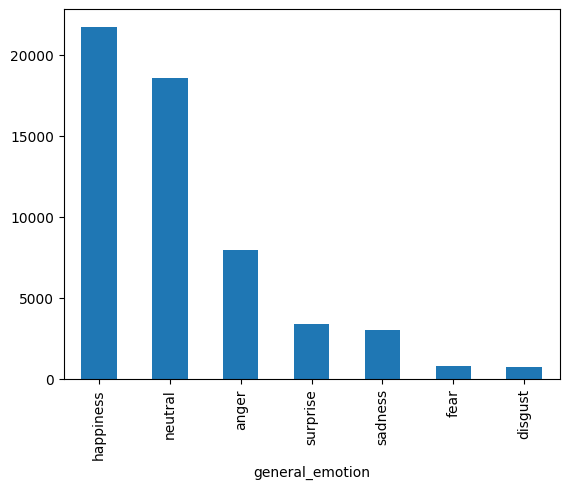

In [16]:
print(cleaned_df.shape)
cleaned_df['general_emotion'].value_counts().plot(kind='bar')

# Drop column length
cleaned_df = cleaned_df.drop(columns=['ru_text_length'], axis=1)

# Dataset CEDR


In [17]:
import pandas as pd

splits = {'train': 'enriched/train-00000-of-00001.parquet', 'test': 'enriched/test-00000-of-00001.parquet'}
df_cedr = pd.read_parquet("hf://datasets/sagteam/cedr_v1/" + splits["train"])

# Add test
df_test_cedr = pd.read_parquet("hf://datasets/sagteam/cedr_v1/" + splits["test"])

# Concatenate the two DataFrames
df_cedr_cc = pd.concat([df_cedr, df_test_cedr], ignore_index=True)
df_cedr_cc = df_cedr_cc.drop(columns=['source', 'sentences'], axis=1)
df_cedr_cc = df_cedr_cc.rename(columns={"text": "ru_text"})

df_cedr_cc['ru_text'] = clean_tweet(df_cedr_cc['ru_text'])

# Remove rows labels with array length more than 1
df_cedr_cc = df_cedr_cc[df_cedr_cc['labels'].apply(lambda x: len(x) <= 1)]

# Transform an array of labels into a single label
def transform_labels(labels):
    if len(labels) == 0:
        return -1
    else:
        return labels[0]
    
# Apply the transformation
df_cedr_cc['labels'] = df_cedr_cc['labels'].apply(transform_labels)

# Map emotions to core emotions
map_cedr = {0: "happiness", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger", -1: "neutral"}
df_cedr_cc['general_emotion'] = df_cedr_cc['labels'].map(map_cedr)

# Drop column labels
df_cedr_cc = df_cedr_cc.drop(columns=['labels'], axis=1)

df_cedr_cc.head(5)


,ru_text,general_emotion
0,Суровый гималайский медведь .,neutral
1,"Так, обнаружено несколько проблем с дисплеем в...",neutral
2,У меня остается только один вопрос является ли...,surprise
3,Забавно как люди в возрасте удивляются входящи...,happiness
4,"Издание The Register отмечает, что у владельце...",neutral


# ChatGpt Dataset of simulated conversations for emotion digust

In [18]:
disgust = pd.read_csv("disgust.csv", delimiter="|")
# Trim whitespace from general_emotion column
disgust['general_emotion'] = disgust['general_emotion'].str.strip()
print(disgust.shape)
print(disgust['general_emotion'].value_counts())

(637, 2)
general_emotion
disgust    637
Name: count, dtype: int64


# DATASET from pipeline

In [19]:
data = pd.read_csv('2024-25c-fai2-adsai-group-team-28-y2c/Deliverables/Task4 - NLP features/group 28_url1.csv') # server
# data = pd.read_csv('group 28_url1.csv')

# Drop first 3 columns
data = data.drop(data.columns[0:3], axis=1)
data = data.drop(columns=['Intensity'], axis=1)

# map emotions to general emotions
data['general_emotion'] = data['Emotion'].map(emotion_mapping)

# Rename columns
data = data.rename(columns={"Corrected Sentence": "ru_text", "Emotion": "emotion", 'Translation': 'text'})

data.head()

,ru_text,text,emotion,general_emotion
0,С понедельника по пятницу пять совершенно разн...,"From Monday to Friday, five completely differe...",neutral,neutral
1,Каждый из них имеет одинаковые условия при пок...,Each of them has the same conditions when buyi...,neutral,neutral
2,И только три часа на приготовление ужина из тр...,And only three hours to make a dinner of three...,neutral,neutral
3,Задача каждого продемонстрировать гостям все с...,The task of everyone is to demonstrate to gues...,neutral,neutral
4,Что подать к столу и как развлекать гостей реш...,What to serve to the table and how to entertai...,neutral,neutral


In [20]:
# Show the shapes of two datasets
print(cleaned_df.shape)
print(data.shape)
print(df_cedr_cc.shape)

(57356, 4)
(1049, 4)
(9283, 2)


In [21]:
# Combine three datasets
combined_df = pd.concat([cleaned_df, df_cedr_cc, disgust], ignore_index=True)
combined_df.dropna(subset=['ru_text', 'general_emotion'], inplace=True)

In [22]:
# Show the shapes of two datasets
print(combined_df.shape)

(66274, 4)


## Balanced Dataset

In [23]:
# # Example: Assume df_combined has a 'general_emotion' column
# class_counts = combined_df['general_emotion'].value_counts()
# min_count = class_counts.min()  # Get the smallest class count

# # Downsample each class to the min_count
# combined_df = combined_df.groupby('general_emotion').apply(lambda x: x.sample(n=min_count, random_state=42))

# # Reset index after groupby operation
# combined_df = combined_df.reset_index(drop=True)

# print(combined_df['general_emotion'].value_counts())  # Verify balance

In [24]:
combined_df = pd.concat([combined_df, data], ignore_index=True)

In [25]:
# Save combined_df (drop emotion)
combined_df = combined_df.drop(columns=['emotion'], axis=1)
combined_df.to_parquet("combined_no_features.parquet")

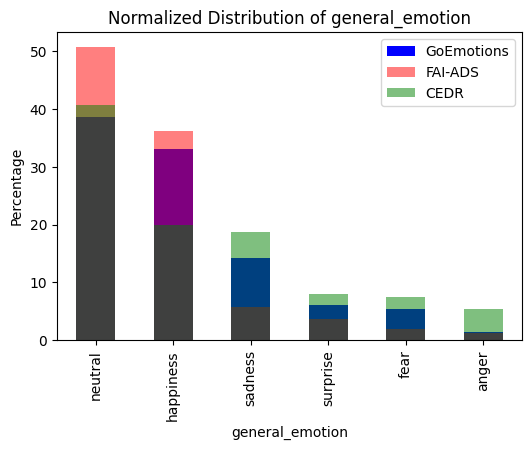

In [61]:
# Visualize the normalized distribution of general_emotion of the two datasets on the same plot with different colors
plt.figure(figsize=(6, 4))
(cleaned_df['general_emotion'].value_counts(normalize=True) * 100).plot(kind='bar', color='blue', alpha=1, label='GoEmotions')
(data['general_emotion'].value_counts(normalize=True) * 100).plot(kind='bar', color='red', alpha=0.5, label='FAI-ADS')
(df_cedr_cc['general_emotion'].value_counts(normalize=True) * 100).plot(kind='bar', color='green', alpha=0.5, label='CEDR')
plt.title('Normalized Distribution of general_emotion')
plt.xlabel('general_emotion')
plt.ylabel('Percentage')
plt.legend()
plt.show()

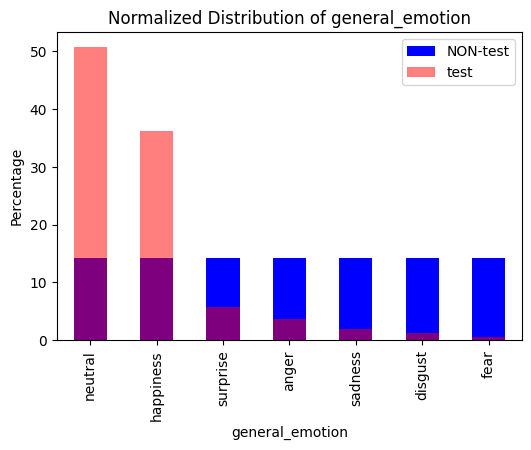

In [63]:
plt.figure(figsize=(6, 4))
(combined_df['general_emotion'].iloc[:-1049].value_counts(normalize=True) * 100).plot(kind='bar', color='blue', alpha=1, label='NON-test')
(combined_df['general_emotion'].iloc[-1049:].value_counts(normalize=True) * 100).plot(kind='bar', color='red', alpha=0.5, label='test')
plt.title('Normalized Distribution of general_emotion')
plt.xlabel('general_emotion')
plt.ylabel('Percentage')
plt.legend()
plt.show()

# FUNCTIONS

RUN TO GET A MODEL FOR EMBEDDINGS wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz


gunzip cc.ru.300.bin.gz


In [64]:
# Load the pre-trained Russian FastText embeddings
model_path = "cc.ru.300.bin"  # Ensure the correct path
fasttext_model = gensim.models.fasttext.load_facebook_vectors(model_path)

INFO: loading 2000000 words for fastText model from cc.ru.300.bin
INFO: FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2025-03-30T13:48:28.203750', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-134-generic-x86_64-with-glibc2.35', 'event': 'created'}
INFO: Updating model with new vocabulary
INFO: FastText lifecycle event {'msg': 'added 2000000 new unique words (100.00% of original 2000000) and increased the count of 0 pre-existing words (0.00% of original 2000000)', 'datetime': '2025-03-30T13:48:38.538991', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-134-generic-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO: deleting the raw counts dictionary of 2000000 items
INFO: sample=1e-05 downsamples 3170 most-common words
INFO: FastText lifecycle event {'msg': 'downsampling leaves estimated 51132317326.65105

In [65]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Russian NLP model
logging.info("Loading spaCy model...")
# in case different language is needed change the ru to other language code
nlp = spacy.load("ru_core_news_lg")

# Add EntityRuler to pipeline
logging.info("Adding custom entity patterns...")
ruler = nlp.add_pipe("entity_ruler", before="ner")
patterns = [
    {"label": "PER", "pattern": name} for name in ["Лидии", "Лидия", "Лидуси", "Лидуся", "Лидией", "Ледуси"]
] + [
    {"label": "ORG", "pattern": name} for name in ["Званный ужин", "Званного ужина"]
]
ruler.add_patterns(patterns)

def seq2vec(sequences):
    ## Vectorize POS tags
    # 1. Initialize and fit Keras Tokenizer
    tokenizer = Tokenizer(oov_token="<UNK>", filters='')
    tokenizer.fit_on_texts(sequences)
    
    # 2. Convert tags to integers
    encoded_sequences = tokenizer.texts_to_sequences(sequences)
    
    # 3. Calculate max length if not provided
    max_len = max(len(seq) for seq in encoded_sequences)
    
    # 3. Pad sequences
    padded_sequences = pad_sequences(
        encoded_sequences,
        maxlen=max_len,
        padding='post',
        truncating='post',
        value=0
    )

    return list(padded_sequences)

def get_tokens(data_set_column, language='russian'):
    """
    Tokenize sentences using NLTK.
    """
    return [nltk.word_tokenize(sent, language=language) for sent in tqdm(data_set_column, desc="Tokenizing sentences")]
    

def get_POS(data_set_column):
    logging.info("Extracting POS tags from sentences using batch processing")
    
    # Process all sentences in parallel using nlp.pipe() with tqdm for progress bar
    docs = list(tqdm(nlp.pipe(data_set_column, disable=["ner", "parser"]), total=len(data_set_column), desc="Extracting POS tags"))

    # Extract POS tags efficiently
    pos_sequences = [[token.pos_ for token in doc] for doc in docs]
    
    padded_output = seq2vec(pos_sequences)

    logging.info("POS tags extracted successfully.")

    return padded_output

def get_tf_idf_with_svd(data_set_column, n_components=100, language='russian'):
    """
    Compute TF-IDF vectors and reduce their dimensions using SVD.
    
    Parameters:
    - data_set_column: List of text data
    - n_components: Number of dimensions to keep after SVD
    
    Returns:
    - Reduced dimensionality TF-IDF matrix as a list
    """
    stop_words = list(nltk.corpus.stopwords.words(language))

    logging.info("Computing TF-IDF...")
    tfidf = TfidfVectorizer(min_df=3, ngram_range=(1, 3), sublinear_tf=True, stop_words=stop_words)
    tfidf_matrix = tfidf.fit_transform(data_set_column)

    logging.info("Applying SVD for dimensionality reduction...")
    svd = TruncatedSVD(n_components=n_components)
    reduced_matrix = svd.fit_transform(tfidf_matrix)

    return reduced_matrix.tolist()

def get_sentiment(data_set_column):
    """
    Compute sentiment scores.
    """
    return [TextBlob(sent).sentiment.polarity for sent in tqdm(data_set_column, desc="Computing sentiment scores")]

def get_pretrained_embeddings(data_set_column):
    """
    Extract sentence embeddings using a pre-trained FastText model (Russian, 300D).
    """
    def sentence_embedding(sentence):
        word_vectors = [fasttext_model[word] for word in sentence if word in fasttext_model]
        if not word_vectors:
            return np.zeros(fasttext_model.vector_size)  # Return zero vector if no words are found
        return np.mean(word_vectors, axis=0)  # Average word vectors to get sentence embedding

    embeddings = list([sentence_embedding(sentence) for sentence in data_set_column])
    return embeddings

def train_custom_word2vec(data_set_column):
    """
    Train a custom Word2Vec model.
    """
    logging.info("Training Word2Vec model...")
    return Word2Vec(sentences=data_set_column, vector_size=300, window=5, workers=4)

def get_custom_embeddings(data_set_column, model):
    """
    Generate sentence embeddings using a trained Word2Vec model.
    """
    sentence_embeddings = []
    
    for sentence in data_set_column:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            avg_vector = sum(vectors) / len(vectors)
        else:
            avg_vector = [0] * model.vector_size
        sentence_embeddings.append(avg_vector)
    
    return sentence_embeddings

def extract_named_entities_per_token(data_set_column):
    named_entities = []
    for sent in tqdm(data_set_column, desc="Extracting named entities"):
        doc = nlp(sent)
        # Initialize a list of None values (for non-entity words)
        labels = [str(np.nan)] * len(doc)
        # Assign entity labels to tokens covered by entities
        for ent in doc.ents:
            for token in ent:
                labels[token.i] = ent.label_
        
        named_entities.append(labels)

    padded_output = seq2vec(named_entities)

    return padded_output

# def lemmatized(data_set_column):
#     """
#     Lemmatize the text.
#     Using spacy.
#     """
#     lemmatizer = nlp.get_pipe("lemmatizer")
#     lemmatizer.add_pipe("lemmatizer", config={"mode": "pymorphy3"})

#     return [[token.lemma_ for token in nlp(sentence, config)] for sentence in tqdm(data_set_column, desc="Lemmatizing")]
    
# def stop_words_filtering(tokenized_text, language='russian'):
#     """
#     Remove stop words.
#     """
#     stop_words = set(nltk.corpus.stopwords.words(language))
#     return [[word for word in sentence if word.lower() not in stop_words] for sentence in tqdm(tokenized_text, desc="Filtering stop words")]
    

logging.info("Pipeline setup complete.")

INFO: Loading spaCy model...
INFO: Loading dictionaries from /root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/pymorphy3_dicts_ru/data
INFO: format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
INFO: Adding custom entity patterns...
INFO: Pipeline setup complete.


In [66]:
# Change the language code if needed
# combined_df['cleaned_text'] = combined_df['ru_text'].str.lower()
combined_df['tokenized'] = get_tokens(combined_df['ru_text'], language='russian')
combined_df['pos_tags'] = get_POS(combined_df['ru_text'])
combined_df['TF_IDF'] = get_tf_idf_with_svd(combined_df['ru_text'], n_components=3, language='russian')
combined_df['named_entities'] = extract_named_entities_per_token(combined_df['ru_text'])

Tokenizing sentences:   0%|          | 0/10912 [00:00<?, ?it/s]

Tokenizing sentences: 100%|██████████| 10912/10912 [00:01<00:00, 10583.47it/s]
INFO: Extracting POS tags from sentences using batch processing
Extracting POS tags: 100%|██████████| 10912/10912 [00:42<00:00, 256.22it/s]
INFO: POS tags extracted successfully.
INFO: Computing TF-IDF...
INFO: Applying SVD for dimensionality reduction...
Extracting named entities: 100%|██████████| 10912/10912 [01:27<00:00, 124.01it/s]


In [67]:
combined_df['pretrained_embeddings'] = get_pretrained_embeddings(combined_df['tokenized'])

custom_word2vec = train_custom_word2vec(combined_df['tokenized'])

combined_df['custom_embeddings'] = get_custom_embeddings(combined_df['tokenized'], custom_word2vec)

INFO: Training Word2Vec model...
INFO: collecting all words and their counts
INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO: PROGRESS: at sentence #10000, processed 143577 words, keeping 25229 word types
INFO: collected 26034 word types from a corpus of 150123 raw words and 10912 sentences
INFO: Creating a fresh vocabulary
INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2729 unique words (10.48% of original 26034, drops 23305)', 'datetime': '2025-03-30T13:51:39.298767', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-134-generic-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 117808 word corpus (78.47% of original 150123, drops 32315)', 'datetime': '2025-03-30T13:51:39.299382', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-134-generic-x86_64

In [68]:
combined_df.head()

,ru_text,text,emotion,general_emotion,tokenized,pos_tags,TF_IDF,named_entities,pretrained_embeddings,custom_embeddings
0,"О боже, человекХ он здесь, потому что ты не сл...",Omg personX he s there because you don t liste...,anger,anger,"[О, боже, ,, человекХ, он, здесь, ,, потому, ч...","[7, 3, 2, 3, 5, 8, 2, 8, 10, 5, 9, 4, 2, 5, 3,...","[0.049742214931586266, 0.246067748492145, -0.0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-0.0066382606, -0.017590161, -0.018125338, -0...","[0.030576168, 0.27334276, 0.0397711, 0.1509149..."
1,"Могу поспорить, вы устали от того, что люди пр...",I bet you get tired of people looking through ...,annoyance,anger,"[Могу, поспорить, ,, вы, устали, от, того, ,, ...","[4, 4, 2, 5, 4, 7, 5, 2, 10, 3, 4, 3, 11, 3, 1...","[0.014475719013516568, 0.00526188809012008, 0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.023441149, -0.04532143, 0.0023011374, 0.044...","[0.021779323, 0.21595497, 0.03274918, 0.118270..."
2,"А еще был тот, кто схватил маму за грудь и поп...",And then there was the on who grabbed mom s br...,annoyance,anger,"[А, еще, был, тот, ,, кто, схватил, маму, за, ...","[12, 8, 14, 11, 2, 5, 4, 3, 7, 3, 12, 4, 4, 5,...","[0.001305419355379824, 0.0013254923030408426, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.04503659, -0.017458426, 0.009537351, -0.007...","[0.022650253, 0.25176293, 0.023268355, 0.12664..."
3,"Уничтожение выгорания. Затем, когда я пытался ...",Burnout takedown. Then when trying to recover ...,disapproval,anger,"[Уничтожение, выгорания, ., Затем, ,, когда, я...","[3, 3, 2, 8, 2, 10, 5, 4, 4, 7, 6, 2, 5, 4, 6,...","[0.004262502635653441, 0.0025379210102163853, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-0.0030044816, -0.039658867, 0.022025786, 0.0...","[0.017996736, 0.22823228, 0.031311635, 0.11563..."
4,Я предпочитаю продолжать вбрасывать деньги в э...,I d rather continue throwing money into these ...,annoyance,anger,"[Я, предпочитаю, продолжать, вбрасывать, деньг...","[5, 4, 4, 4, 3, 7, 11, 6, 3, 2, 10, 4, 5, 7, 6...","[0.005679983230965895, 0.0033794104401030116, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.009746693, -0.0066950456, 0.034261893, 0.03...","[0.021388112, 0.248662, 0.023290874, 0.1245827..."


In [69]:
np.unique([seq for seq in combined_df['pos_tags']])

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int32)

In [70]:
np.unique([seq for seq in combined_df['named_entities']])

array([0, 2, 3, 4, 5], dtype=int32)

In [71]:
# ner = data[['Corrected Sentence', 'Named_Entities']]
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.cluster import DBSCAN
# import plotly.express as px
# import numpy as np

# embeddings = np.array(data['Pretrained_embeddings'].tolist())
# sentences = data['Corrected Sentence']

# # Apply t-SNE to reduce dimensions
# embeddings_2d = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(embeddings)

# # Apply DBSCAN clustering
# dbscan = DBSCAN(eps=2, min_samples=2).fit(embeddings_2d)
# labels = dbscan.labels_

# # Create DataFrame for visualization
# df = pd.DataFrame({
#     "x": embeddings_2d[:, 0],
#     "y": embeddings_2d[:, 1],
#     "sentence": sentences,
#     "cluster": labels.astype(str)
# })

# # Plot interactive scatter plot
# fig = px.scatter(
#     df, x="x", y="y", color="cluster",
#     hover_data={"sentence": True, "x": False, "y": False, "cluster": True},
#     title="Sentence Embeddings Visualized with t-SNE and DBSCAN"
# )
# fig.show()

In [72]:
# Convert array columns to string before saving
output_df = combined_df.copy()
output_df['TF_IDF'] = combined_df['TF_IDF'].apply(lambda x: ','.join(map(str, x)))
output_df['pretrained_embeddings'] = combined_df['pretrained_embeddings'].apply(lambda x: ','.join(map(str, x)))
output_df['custom_embeddings'] = combined_df['custom_embeddings'].apply(lambda x: ','.join(map(str, x)))
output_df['pos_tags'] = combined_df['pos_tags'].apply(lambda x: ','.join(map(str, x)))
output_df['named_entities'] = combined_df['named_entities'].apply(lambda x: ','.join(map(str, x)))

In [73]:
# Drop Tokenized and POS_tags columns
output_df = output_df.drop(["tokenized"], axis=1)

In [74]:
output_df.head()

,ru_text,text,emotion,general_emotion,pos_tags,TF_IDF,named_entities,pretrained_embeddings,custom_embeddings
0,"О боже, человекХ он здесь, потому что ты не сл...",Omg personX he s there because you don t liste...,anger,anger,"7,3,2,3,5,8,2,8,10,5,9,4,2,5,3,2,0,0,0,0,0,0,0...","0.049742214931586266,0.246067748492145,-0.0193...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,...","-0.0066382606,-0.017590161,-0.018125338,-0.072...","0.030576168,0.27334276,0.0397711,0.15091494,0...."
1,"Могу поспорить, вы устали от того, что люди пр...",I bet you get tired of people looking through ...,annoyance,anger,"4,4,2,5,4,7,5,2,10,3,4,3,11,3,12,4,11,3,2,10,8...","0.014475719013516568,0.00526188809012008,0.003...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...","0.023441149,-0.04532143,0.0023011374,0.0441399...","0.021779323,0.21595497,0.03274918,0.11827041,0..."
2,"А еще был тот, кто схватил маму за грудь и поп...",And then there was the on who grabbed mom s br...,annoyance,anger,"12,8,14,11,2,5,4,3,7,3,12,4,4,5,7,3,3,2,0,0,0,...","0.001305419355379824,0.0013254923030408426,0.0...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,...","0.04503659,-0.017458426,0.009537351,-0.0078370...","0.022650253,0.25176293,0.023268355,0.12664051,..."
3,"Уничтожение выгорания. Затем, когда я пытался ...",Burnout takedown. Then when trying to recover ...,disapproval,anger,"3,3,2,8,2,10,5,4,4,7,6,2,5,4,6,3,3,2,0,0,0,0,0...","0.004262502635653441,0.0025379210102163853,0.0...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,...","-0.0030044816,-0.039658867,0.022025786,0.01329...","0.017996736,0.22823228,0.031311635,0.11563357,..."
4,Я предпочитаю продолжать вбрасывать деньги в э...,I d rather continue throwing money into these ...,annoyance,anger,"5,4,4,4,3,7,11,6,3,2,10,4,5,7,6,3,3,3,2,0,0,0,...","0.005679983230965895,0.0033794104401030116,0.0...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,...","0.009746693,-0.0066950456,0.034261893,0.030210...","0.021388112,0.248662,0.023290874,0.12458279,0...."


In [75]:
output_df.to_excel('nlp_balanced.xlsx', index=False)